In [1]:
# Now to try out running a type Ia SN detection thing


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic
# Make the notebook repeatable
import gzip
import pickle
np.random.seed(42)



In [2]:
def destination(ra1, dec1, bearing, ang_dist):
    """Find the final point given a bearing and distance
    https://www.movable-type.co.uk/scripts/latlong.html
    
    everything in radians
    
    bearing : float
        The bearing clockwise from north (radians)
    """
    sin_dec = np.sin(dec1)
    cos_dec = np.cos(dec1)
    cos_dist = np.cos(ang_dist)
    sin_dist = np.sin(ang_dist)
    
    cos_bearing = np.cos(bearing)
    sin_bearing = np.sin(bearing)
    
    dec_out = np.arcsin(sin_dec*cos_dist + cos_dec*sin_dist*cos_bearing)
    
    ra_out = ra1 + np.arctan2(sin_bearing*sin_dist*cos_dec, 
                             cos_dist-sin_dec*np.sin(dec_out))
    
    ra_out = ra_out % (2.*np.pi)
    
    return ra_out, dec_out
    

In [3]:
def rand_around_point(ra, dec, dist_max, npts):
    """Generate random point within some distance of a point on a sphere
    """
    r = dist_max*np.sqrt(np.random.rand(npts))
    theta = np.random.rand(npts)*2*np.pi
    
    ras, decs = destination(ra, dec, theta, r)
    return ras, decs
    

In [4]:
def rand_on_sphere(npts):
    """Put point on a sphere randomly
    """
    ra = 2.*np.pi * np.random.rand(npts)
    dec = np.arccos(2.*np.random.rand(npts)-1) - np.pi/2
    return ra, dec

In [5]:
# Read in the type 1a light curves
with gzip.open('IDEAL_z02_MODEL11.pkl.gz', 'rb') as f:
    lcs = pickle.load(f)


In [6]:
objids = list(lcs.keys())
lcs[objids[1]].keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'Y', 'header'])

In [7]:
n_obj = np.size(objids)
ra,dec = rand_on_sphere(n_obj)
# peak times
survey_length = 365.25*10
mjd0 = 59853.5
peak_times = np.random.rand(n_obj)*survey_length + mjd0

In [8]:
def plasticc2mags(plc, mjds, filters, peak_time=0, zp=27.5):
    """take a plasticc lightcurve dict and return interpolated mags
    
    plc : unpickled plasticc light curve
        The template light curve
    mjds : np.array
        The MJD values we want to interpolate to
    filters : np.array (string)
        The filters. Should be same length as mjds
    peak_time : float (0)
        The MJD to have the peak of the light curve
    zp : float (27.5)
        The zeropoint of the plc
    """
    
    # Need a dictionary to translate y to Y. Hopefully those aren't actually different filters?
    filttrans = {'u':'u', 'g': 'g', 'r': 'r', 'i':'i', 'z':'z', 'y': 'Y'}
    result = np.zeros(mjds.size, dtype=float)
    for filtername in np.unique(filters):
        infilt = np.where(filters == filtername)[0]
        lc_mjd = plc[filttrans[filtername]]['mjd'] - plc['header']['SIM_PEAKMJD'] + peak_time
        result[infilt] = -2.5*np.log10(np.interp(mjds, lc_mjd, plc[filttrans[filtername]]['fluxcal'], left=-1, right=-1)) + zp
    return result



In [9]:
lcs[objids[1]]['g'].keys()


dict_keys(['mjd', 'fluxcal', 'fluxcalerr', 'photflag'])

In [10]:
lcs[objids[1]]['header']

{'SIM_AV': -9.0,
 'SIM_DECL': 0.0,
 'SIM_DLMU': 34.699596,
 'SIM_EXPOSURE_Y': 1000.0,
 'SIM_EXPOSURE_g': 1000.0,
 'SIM_EXPOSURE_i': 1000.0,
 'SIM_EXPOSURE_r': 1000.0,
 'SIM_EXPOSURE_u': 1000.0,
 'SIM_EXPOSURE_z': 1000.0,
 'SIM_LENSDMU': -0.00053625647,
 'SIM_LIBID': 1,
 'SIM_MAGSMEAR_COH': -0.033319704,
 'SIM_MODEL_INDEX': 6,
 'SIM_MODEL_NAME': 'SALT2.WFIRST-H17                ',
 'SIM_MWEBV': 0.0,
 'SIM_NGEN_LIBID': 2,
 'SIM_NOBS_UNDEFINED': 0,
 'SIM_PEAKMAG_Y': 16.706293,
 'SIM_PEAKMAG_g': 15.45697,
 'SIM_PEAKMAG_i': 16.057625,
 'SIM_PEAKMAG_r': 15.524377,
 'SIM_PEAKMAG_u': 15.959028,
 'SIM_PEAKMAG_z': 16.254612,
 'SIM_PEAKMJD': 53100.539,
 'SIM_RA': 0.0,
 'SIM_REDSHIFT_CMB': 0.020000558,
 'SIM_REDSHIFT_HELIO': 0.021226143,
 'SIM_REDSHIFT_HOST': 0.021226143,
 'SIM_RV': -9.0,
 'SIM_SALT2alpha': 0.14,
 'SIM_SALT2beta': 3.0999999,
 'SIM_SALT2c': 0.001939774,
 'SIM_SALT2mB': 15.298226,
 'SIM_SALT2x0': 0.013636707,
 'SIM_SALT2x1': 0.30275166,
 'SIM_SEARCHEFF_MASK': 3,
 'SIM_SUBSAMPLE_INDE

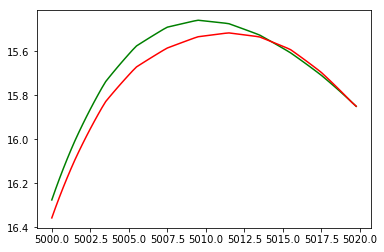

In [11]:
mjds = np.arange(5000, 5020, .25)
filters = np.array(['g']*np.size(mjds))
out_mags = plasticc2mags(lcs[objids[1]], mjds, filters, peak_time=5010)
plt.plot(mjds, out_mags, 'g-')
filters = np.array(['r']*np.size(mjds))
out_mags = plasticc2mags(lcs[objids[1]], mjds, filters, peak_time=5010)
plt.plot(mjds, out_mags, 'r-')
plt.gca().invert_yaxis()

In [12]:
ra, dec = rand_around_point(np.radians(30),np.radians(-60),np.radians(5), 50)

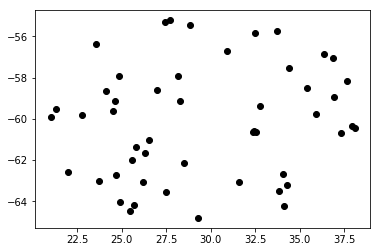

In [13]:
plt.plot(np.degrees(ra), np.degrees(dec), 'ko')

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


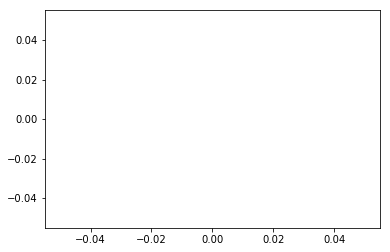

In [14]:
# What happens if we try to get mags out side range?
mjds = np.arange(5000, 5020, .25)
filters = np.array(['g']*np.size(mjds))
out_mags = plasticc2mags(lcs[objids[1]], mjds+500, filters, peak_time=5010)
plt.plot(mjds, out_mags, 'g-')

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


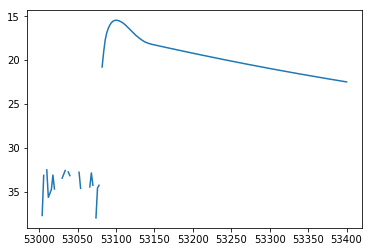

In [15]:
plt.plot(lcs[objids[1]]['g']['mjd'], -2.5*np.log10(lcs[objids[1]]['g']['fluxcal']) +27.5)
plt.gca().invert_yaxis()